In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import matplotlib
from tsfresh.examples.har_dataset import download_har_dataset, load_har_dataset, load_har_classes
# import seaborn as sns
from localtsfresh.tsfresh import extract_features, extract_relevant_features, select_features
from localtsfresh.tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters, EfficientFCParameters, MinimalFCParameters
from sklearn.tree import DecisionTreeClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from pandas import DataFrame
import pandas as pd
import numpy as np
import os
import math

import logging

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.signal import butter, lfilter, lfilter_zi
from numpy import linalg as LA
from xgboost import XGBClassifier
import copy
from collections import Counter

# We set the logger to Error level
# This is not recommend for normal use as you can oversee important Warning messages
logging.basicConfig(level=logging.ERROR)

#根据Win，生成DataFrame格式中的Time列
def getTimeColumn(win):
    time=np.arange(win)
    for idx in range(1, sensornum):
        timetmp=np.arange(win)
        time=np.concatenate((time, timetmp), axis=0)
    time.shape=(len(time),1)
    return time

#根据Win和数据，生成DataFrame格式中的kind和value列
def getKindValueColumn(sd, win):
    for i in range(sensornum):
        kind=i*np.ones((win, 1),dtype=int)
        sensorcols=sd[i]
        sensorcols.shape=(win, 1)
        sdata=np.column_stack((kind, sensorcols))
        if i==0:
            sensorframe=sdata
        else:
            sensorframe=np.row_stack((sensorframe, sdata))
    return sensorframe

def getIdColumn(num, win):
    for i in range(num):
        if i==0:
            idary=0*np.ones((sensornum*win, 1))
        else:
            idary=np.row_stack((idary, i*np.ones((sensornum*win, 1))))
    return idary

def getDataLabelColumn(dataary,label, num, win):
    for i in range(filenum):
        if i==0:
            y=label[travel[i]][:num]
            data=dataary[travel[i]][:num*win*sensornum]
        else:
            y=np.row_stack((y, label[travel[i]][:num]))
            data=np.row_stack((data, dataary[travel[i]][:num*win*sensornum]))
    y.shape=(len(y),)
    y=pd.Series(y)
    return data, y


#读取所有数据，结果是字典，分别存储六种运动的传感器读数矩阵，每个矩阵的三列分别是time, kind, value
def loadData(win, step, sampling):
    labeldict={}
    datadict={}
    files = os.listdir('/home/hadoop/data')
    if step<=win:
        for i in range(0, filenum):
            with open('/home/hadoop/data/%s' % files[i], 'r') as f:
                sensordata=np.loadtxt(f, delimiter=",")[::2, :]
                
                ########## feature extraction ###########
                sensordata = np.delete(sensordata, np.s_[:3], 1)
                sensordata[:, 2] = sensordata[:, 2] - 9.8012
                sensordata = resample(sensordata, sampling)
                
                #mi = LA.norm(sensordata, 2, axis=1)
                #sma = np.sum(np.abs(sensordata), 1)
                #velo = calcVelo(sensordata[:,:2], fs, win)
                #sensordata = np.c_[sensordata, mi, sma]
                
                #loadDataPlot(sensordata, i)
                
                ########## filter ############
                #fltr2(sensordata, cutOff=15, fs=fs, order=5)
                #########################################
                
                max_num=int((len(sensordata)-win)/step)+1
                for j in range(0, max_num):
                    start_idx=step*j
                    end_idx=step*j+win
                    sd=sensordata[start_idx:end_idx,:]
                    sd=sd.transpose()
                        
                    time=getTimeColumn(win)
                    kindvalue=getKindValueColumn(sd, win)
                    travary=np.column_stack((time, kindvalue ))

                    if j == 0:
                        dataarray=travary
                    else:
                        dataarray=np.concatenate((dataarray, travary), axis=0)  

                labeldict[travel[i]]=i*np.ones((max_num, 1), dtype=int)
                datadict[travel[i]]=dataarray
                print(files[i]+" loaded!")
        use_num_max=filenum*max_num
        return datadict, labeldict, use_num_max
    else:
        raise IOError('\'step\' of slide window shoud be less than \'win\'')

#从所有数据dataary和其标签label中，选出总数为num的样本，每个类别选num/sensornum个样本。
def genTrainSample(dataary, label, num, win):
    idary=getIdColumn(num, win)
    labelnum=int(num/filenum) ;
    data, y=getDataLabelColumn(dataary, label, labelnum, win)
    data=np.column_stack((idary, data))
    dataframe = DataFrame(data, columns=['id', 'time', 'kind', 'value'])
    return dataframe, y


#画出第idx个样本3个传感器的数据
def plotSample(data, kind, idx, win, use_num):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)
    tmp=data.iloc[:, -1].values
    for i in range(sensornum):
        plt.subplot(3,2,i+1)
        plt.title(sensor[i] + ' readings')
        begin=kind*win*use_num + idx*win*sensornum + win*i
        end=begin+win-1
        plt.plot(tmp[begin:end])
    plt.show()
    
def loadDataPlot(data, ind):
    plt.figure(ind)
    for i in xrange(0, data.shape[1]):
        fig = matplotlib.pyplot.gcf()
        fig.set_size_inches(18.5, 10.5)
        plt.subplot(3,2,i+1)
        plt.plot(data[:, i])
    return

################ Resampling ##################

def resample(data, sampling):
    ind = np.arange(0, data.shape[0], sampling)
    return data[ind, :]

################ Calculate Velocity ###################

def calcVelo(acc, fs, win):
    velo = np.zeros(acc.shape)
    for i in xrange(0, acc.shape[0]):
        if i % win: 
            velo[i] = velo[i-1] + (acc[i-1]+acc[i])/(2*fs)
    return LA.norm(velo, 2, axis=1)
        

################ Butterworth 滤波 ###################

def butter_lowpass(cutOff, fs, order=5):
    nyq = 0.5 * fs
    normalCutoff = cutOff / nyq
    b, a = butter(order, normalCutoff, btype='low', analog = False)
    return b, a

def fltr(data, win, sensornum, cutOff, fs, order=5): #这个是在滑窗之后滤波的函数
    v = data.iloc[:, -1].values
    b, a = butter_lowpass(cutOff, fs, order)
    zi = np.tile(lfilter_zi(b, a), (sensornum,1))
    for i in xrange(0, v.size, win*sensornum):
        for j in xrange(0, sensornum):
            x = v[i+j*win: i+(j+1)*win]
            y, zi[j]= lfilter(b, a, x, zi=zi[j])
            data.iloc[i+j*win: i+(j+1)*win, -1] = y
    return

def fltr2(sensordata, cutOff, fs, order):  #这个是在数据读取后马上就滤波的函数
    b, a = butter_lowpass(cutOff, fs, order)
    for n in xrange(sensordata.shape[1]):
        zi = lfilter_zi(b, a)
        sensordata[:,n], zi = lfilter(b, a, sensordata[:,n], zi=zi)


localtsfresh_init!
feature_extraction_init
tsfresh_init!


In [2]:
#可修改常量
# 六种出行方式
travel=["bus", "car", "running", "stationary", "subway", "walking"]
# 六个传感器数据
sensor=["acc_x", "acc_y", "acc_z"]#, "mi", "sma"]
#sensor=["azimath", "pitch", "roll"]
# 一些常量
filenum=6
#窗口步长大小
sampling=5         #采样间隔，注意，win是在采样间隔基础上算的
win=400/sampling
step=win/2           #步长应该小于等于win
#使用的样本数量(一个窗口的数据是一个样本)，建议设置成sensornum的倍数
fs = 100/sampling

sensornum=len(sensor)
data, label, use_num_max = loadData(win, step, sampling)

print("\n \033[1;33;48m NOTE: use_num should be less than %s"%(use_num_max))

bus_data_set_101 loaded!
car_data_set_103 loaded!
running_data_set_8 loaded!
stationary_data_set_3 loaded!
subway_data_set_102 loaded!
walking_data_set_7 loaded!

  NOTE: use_num should be less than 1818


In [3]:
use_num = use_num_max
df, y=genTrainSample(data, label, use_num, win)

######## Low Pass Filter ##########
kind=0
idx=10
#plotSample(df, kind,idx, win, use_num)

#fltr(df, win, sensornum, cutOff=8, fs=fs, order=5) #filter

master_df = df
print(master_df.shape)

(436320, 4)


In [40]:
sma = np.zeros((use_num,1))
ind = 0
for i in xrange(0, df.shape[0], win*sensornum):
    sma[ind] = np.sum(np.abs(df.iloc[i: i+win*sensornum, -1].values))/win
    ind += 1

In [4]:
# extraction_settings = ComprehensiveFCParameters()
extraction_settings = EfficientFCParameters()
# extraction_settings = MinimalFCParameters()
#extraction_settings.update({"fft_dc":None,"fft_mean":None,"fft_var":None,"fft_std":None,"fft_kurt":None,"fft_shape_mean":None,"fft_shape_std":None,"fft_shape_skew":None,"fft_shape_kurt":None})

"""
extraction_settings = {'ar_coefficient': [{'coeff': 0, 'k': 10},
    {'coeff': 1, 'k': 10},
    {'coeff': 2, 'k': 10},
    {'coeff': 3, 'k': 10},
    {'coeff': 4, 'k': 10}],
          'autocorrelation': [{'lag': 0},{'lag': 1},{'lag': 2},{'lag': 3},{'lag': 4},
                              {'lag': 5},{'lag': 6},{'lag': 7},{'lag': 8},{'lag': 9}],
          'quantile': [{'q': 0.1},{'q': 0.2},{'q': 0.3},{'q': 0.4},
                       {'q': 0.6},{'q': 0.7},{'q': 0.8},{'q': 0.9}],
          'number_peaks': [{'n': 1}, {'n': 3}, {'n': 5}],
          'minimum': None,
          'maximum': None,
          'median': None,
          'sum_values': None,
}
"""

%time X = extract_features(master_df, default_fc_parameters=extraction_settings, column_id='id', column_sort="time", column_kind="kind", column_value="value");
# %time X = extract_features(master_df, column_id='id', column_sort="time", column_kind="kind", column_value="value");

# in total we have transformed the sensor data into 222 features
impute(X)

#X['SMA'] = sma
X.shape

It is ok!


Feature Extraction: 100%|██████████| 5454/5454 [05:13<00:00, 17.38it/s]


CPU times: user 6.4 s, sys: 571 ms, total: 6.97 s
Wall time: 5min 17s


(1818, 807)

In [5]:
for n in X.columns:
    std = np.std(X[n])
    X[n] = (X[n]-np.mean(X[n]))/std if std>0 else X[n]-np.mean(X[n])

In [93]:
X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, y, test_size=.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp, test_size=.125)

# 整体模型

In [ ]:
#20Hz, 4s, no validation, 0.3 test data, 0.913, std = 0.012821
from SFFS import SFFS

selected_ftr = []
for j in xrange(0, 20):
    X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, y, test_size=.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp, test_size=.125)
    eval_set = [(X_val, y_val)]
    SFFS_ftr = SFFS(X_train, y_train, X_val, y_val)
    
    for i, s in enumerate(SFFS_ftr):
        SFFS_ftr[i] = s[3:]
    
    selected_ftr.append(SFFS_ftr)
    print('Loop = %d' % i+1)

In [29]:
#Using all the features as contrast

cl = XGBClassifier(max_depth=5, n_estimators=300, objective='multi:softmax', reg_lambda=2)
cl.fit(X_train, y_train)
score = accuracy_score(y_test, cl.predict(X_test))
print(score)


0.919413919414


In [6]:
#20Hz, 4s, no validation, 0.3 test data, 0.913, std = 0.012821
for i in xrange(3, 4):
    score = []
    for j in xrange(0, 100):
        #X_train_tmp, X_test, y_train_tmp, y_test = train_test_split(X, y, test_size=.2)
        #X_train, X_val, y_train, y_val = train_test_split(X_train_tmp, y_train_tmp, test_size=.125)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1*i)
        #eval_set = [(X_val, y_val)]
        cl = XGBClassifier(max_depth=5, n_estimators=300, objective='multi:softmax', reg_lambda=2)
        #cl.fit(X_train, y_train, eval_metric='mlogloss', eval_set=eval_set, early_stopping_rounds=20, verbose=False)
        cl.fit(X_train, y_train)
        score.append(accuracy_score(y_test, cl.predict(X_test)))
        print(score[-1])
    print('test size = %f, Mean accuracy is %f, std = %f' % (0.1*i, np.mean(score), np.std(score)))
    

0.952424519671
0.953339432754
0.943275388838
0.947849954254
0.946935041171
0.944190301921
0.931381518756
0.952424519671
0.950594693504
0.943275388838
0.95791399817
0.947849954254
0.954254345837
0.958828911253
0.95516925892
0.950594693504
0.948764867338
0.940530649588
0.948764867338
0.939615736505
0.947849954254
0.954254345837
0.947849954254
0.953339432754
0.95516925892
0.950594693504
0.945105215005
0.95516925892
0.941445562672
0.954254345837
0.961573650503
0.941445562672
0.945105215005
0.948764867338
0.939615736505
0.947849954254
0.935956084172
0.946020128088
0.95791399817
0.946935041171
0.952424519671
0.949679780421
0.946935041171
0.950594693504
0.944190301921
0.958828911253
0.952424519671
0.945105215005
0.947849954254
0.951509606587
0.953339432754
0.946935041171
0.956999085087
0.950594693504
0.953339432754
0.949679780421
0.953339432754
0.948764867338
0.95516925892
0.949679780421
0.953339432754
0.952424519671
0.958828911253
0.95791399817
0.931381518756
0.935041171089
0.936870997255
0.

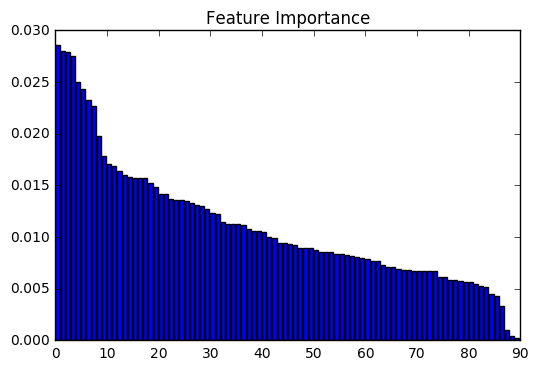

Index([u'2.0__ar_coefficient__k_10__coeff_0',
       u'2.0__ar_coefficient__k_10__coeff_3', u'2.0__sum_values',
       u'2.0__maximum', u'1.0__minimum', u'2.0__autocorrelation__lag_6',
       u'2.0__ar_coefficient__k_10__coeff_2', u'2.0__autocorrelation__lag_5',
       u'0.0__minimum', u'2.0__quantile__q_0.6',
       u'0.0__ar_coefficient__k_10__coeff_4', u'2.0__number_peaks__n_5',
       u'2.0__ar_coefficient__k_10__coeff_1', u'2.0__number_peaks__n_1',
       u'2.0__median', u'0.0__maximum', u'2.0__quantile__q_0.7',
       u'0.0__ar_coefficient__k_10__coeff_3', u'0.0__quantile__q_0.1',
       u'2.0__autocorrelation__lag_7', u'2.0__quantile__q_0.8',
       u'2.0__quantile__q_0.1', u'1.0__ar_coefficient__k_10__coeff_2',
       u'1.0__ar_coefficient__k_10__coeff_0', u'2.0__minimum', u'1.0__maximum',
       u'1.0__ar_coefficient__k_10__coeff_3',
       u'2.0__ar_coefficient__k_10__coeff_4', u'1.0__number_peaks__n_1',
       u'2.0__number_peaks__n_3', u'2.0__quantile__q_0.9',
       u'1.0_

In [7]:
# plot
ind = np.argsort(-cl.feature_importances_)
plt.bar(range(len(cl.feature_importances_)), cl.feature_importances_[ind])
plt.title('Feature Importance')
plt.show()
print(X.columns[ind[:50]])

In [14]:
confusion

,0,1,2,3,4,5
0,54,9,0,0,6,0
1,13,65,0,1,3,0
2,0,0,82,0,1,1
3,0,0,0,91,0,0
4,7,6,0,1,74,0
5,0,0,0,0,0,71


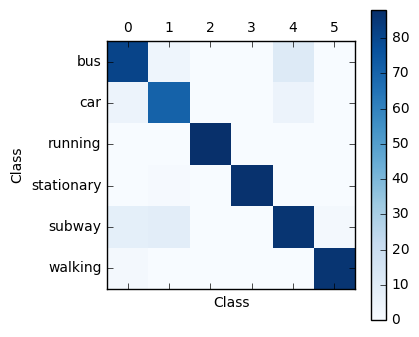

In [52]:
from sklearn.metrics import confusion_matrix

confusion = pd.DataFrame(confusion_matrix(y_test, cl.predict(X_test)))

def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, range(0,6))
    plt.yticks(tick_marks, travel)
    #plt.tight_layout()
    plt.ylabel('Class')
    plt.xlabel('Class')

plot_confusion_matrix(confusion)

In [27]:
cand = 100
loop = 20
selected_ftr = np.array([])
mean = 0
for i in xrange(0, loop):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
    X_train_fs, X_val, y_train_fs, y_val = train_test_split(X_train, y_train, test_size=.25)
    
    eval_set = [(X_val, y_val)]
    cl = XGBClassifier(max_depth=5, n_estimators=200, objective='multi:softmax', reg_lambda=2)
    cl.fit(X_train, y_train, eval_metric='mlogloss', eval_set=eval_set, early_stopping_rounds=20, verbose=False)
    score = accuracy_score(y_test, cl.predict(X_test))

    mean += score
    print('Loop %d, accuracy is %f' % (i, score))
    selected_ftr = np.append(selected_ftr, np.argsort(-cl.feature_importances_)[:cand])
print('Mean Accuracy is %f' % (mean/loop))

ftr = []
for key, value in dict(Counter(list(selected_ftr))).iteritems():
    if value >= loop*1/2:
        ftr.append(key)
ftr2 = X.columns.values[ftr]

Loop 0, accuracy is 0.952263
Loop 1, accuracy is 0.953909
Loop 2, accuracy is 0.948148
Loop 3, accuracy is 0.941564
Loop 4, accuracy is 0.951440
Loop 5, accuracy is 0.939918
Loop 6, accuracy is 0.937449
Loop 7, accuracy is 0.944856
Loop 8, accuracy is 0.947325
Loop 9, accuracy is 0.944033
Loop 10, accuracy is 0.947325
Loop 11, accuracy is 0.947325
Loop 12, accuracy is 0.945679
Loop 13, accuracy is 0.946502
Loop 14, accuracy is 0.953909
Loop 15, accuracy is 0.952263
Loop 16, accuracy is 0.943210
Loop 17, accuracy is 0.952263
Loop 18, accuracy is 0.939095
Loop 19, accuracy is 0.950617
Mean Accuracy is 0.946955


/home/hadoop/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:23: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


# 分层模型

In [56]:
def firstLevelY(kind, y):
    for i in xrange(0, kind.shape[0]):
        for j, n in enumerate(kind[i]):
            y[np.nonzero(y==n)] = i
    return y

kind = np.array([[0, 1, 4], [2, 3, 5]])
y_train_hier = copy.deepcopy(y_train.values)
y_train_hier = pd.Series(firstLevelY(kind, y_train_hier))
y_val_hier = copy.deepcopy(y_val.values)
y_val_hier = pd.Series(firstLevelY(kind, y_val_hier))
y_test_hier = copy.deepcopy(y_test.values)
y_test_hier = pd.Series(firstLevelY(kind, y_test_hier))

## 训练第一层模型

In [57]:
eval_set = [(X_val, y_val_hier)]
cl_1st = XGBClassifier(max_depth=6, n_estimators=200, objective='binary:logistic', reg_lambda=1)
cl_1st.fit(X_train, y_train_hier, eval_metric='error', eval_set=eval_set, early_stopping_rounds=30, verbose=False)
score = accuracy_score(y_test_hier, cl_1st.predict(X_test))
print(score)

0.983516483516


## 训练第二层模型

In [58]:
X_train_human = X_train.iloc[np.nonzero(y_train_hier.values)[0],:]
y_train_human = pd.Series(y_train.values[np.nonzero(y_train_hier.values)[0]])
X_val_human = X_val.iloc[np.nonzero(y_val_hier.values)[0],:]
y_val_human = pd.Series(y_val.values[np.nonzero(y_val_hier.values)[0]])
X_test_human = X_test.iloc[np.nonzero(y_test_hier.values)[0],:]
y_test_human = pd.Series(y_test.values[np.nonzero(y_test_hier.values)[0]])

X_train_motor = X_train.iloc[np.nonzero(y_train_hier.values==0)[0],:]
y_train_motor = pd.Series(y_train.values[np.nonzero(y_train_hier.values==0)[0]])
X_val_motor = X_val.iloc[np.nonzero(y_val_hier.values==0)[0],:]
y_val_motor = pd.Series(y_val.values[np.nonzero(y_val_hier.values==0)[0]])
X_test_motor = X_test.iloc[np.nonzero(y_test_hier.values==0)[0],:]
y_test_motor = pd.Series(y_test.values[np.nonzero(y_test_hier.values==0)[0]])

############### Human Model ################
eval_set = [(X_val_human, y_val_human)]
cl_human = XGBClassifier(max_depth=6, n_estimators=200, objective='multi:softmax', reg_lambda=1)
cl_human.fit(X_train_human, y_train_human, eval_metric='merror', eval_set=eval_set, early_stopping_rounds=30, verbose=False)
score = accuracy_score(y_test_human, cl_human.predict(X_test_human))
print(score)

############## Motor Model #################
eval_set = [(X_val_motor, y_val_motor)]
cl_motor = XGBClassifier(max_depth=5, n_estimators=200, objective='multi:softmax', reg_lambda=1)
cl_motor.fit(X_train_motor, y_train_motor, eval_metric='merror', eval_set=eval_set, early_stopping_rounds=30, verbose=False)
score = accuracy_score(y_test_motor, cl_motor.predict(X_test_motor))
print(score)

0.989189189189
0.815642458101


## Evaluation

In [59]:
y_pred_1st = cl_1st.predict(X_test)
correct = set(np.nonzero(y_pred_1st == y_test_hier.values)[0])
error_num = y_test.shape[0] - len(correct)
X_test_human = X_test.iloc[list(set(np.nonzero(y_test_hier.values)[0]) & correct), :]
y_test_human = y_test.iloc[list(set(np.nonzero(y_test_hier.values)[0]) & correct)]
X_test_motor = X_test.iloc[list(set(np.nonzero(y_test_hier.values==0)[0]) & correct), :]
y_test_motor = y_test.iloc[list(set(np.nonzero(y_test_hier.values==0)[0]) & correct)]

y_pred_human = cl_human.predict(X_test_human)
error_num += np.nonzero(y_pred_human != y_test_human.values)[0].size
y_pred_motor = cl_motor.predict(X_test_motor)
error_num += np.nonzero(y_pred_motor != y_test_motor.values)[0].size
print('Score = %f' % (1-float(error_num)/y_test.shape[0]))

Score = 0.892857


In [287]:
#ftr = X.columns.values[np.argsort(-cl.feature_importances_)[:50]]
#ftr = X.columns.values[ftr]
#print(ftr)
#ftr = new_ftr
tmp_X_train = X_train.loc[:, ftr]
tmp_X_test = X_test.loc[:, ftr]
fs_cl = XGBClassifier()
fs_cl.fit(tmp_X_train, y_train)
score = accuracy_score(y_test, fs_cl.predict(tmp_X_test))
print(score)

0.932098765432


In [12]:
import copy

dlt = ['range_count', 'augmented_dickey_fuller', 'binned_entropy', 'number_cwt_peaks', 'friedrich_coefficients',
      'mean_autocorrelation', 'sum_of_reoccurring_values', 'abs_energy', 'agg_linear_trend__f_agg', 'kurtosis']
ind = []
for i, string in enumerate(selected_ftr):
    for s in dlt:
        if string.find(s) >= 0:
            ind.append(i)
            break
new_ftr = np.delete(selected_ftr, ind)
new_ftr
            

NameError: name 'ftr2' is not defined

/home/hadoop/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: VisibleDeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


In [73]:
SFFS_ftr = SFFS(X_train_fs, y_train_fs, X_val, y_val)

Loop = 1, Maximum Score = 0.729767, Feature Num = 1
Loop = 2, Maximum Score = 0.761317, Feature Num = 2
Loop = 3, Maximum Score = 0.836077, Feature Num = 3
Loop = 4, Maximum Score = 0.877915, Feature Num = 4
Loop = 5, Maximum Score = 0.888889, Feature Num = 5
Loop = 6, Maximum Score = 0.899177, Feature Num = 6
Loop = 7, Maximum Score = 0.901920, Feature Num = 7
Loop = 8, Maximum Score = 0.908779, Feature Num = 8
Loop = 9, Maximum Score = 0.912894, Feature Num = 9
Loop = 10, Maximum Score = 0.920439, Feature Num = 9
Loop = 11, Maximum Score = 0.921811, Feature Num = 10
Loop = 12, Maximum Score = 0.921811, Feature Num = 10
Feature Selection Completed!


In [76]:
ftr = SFFS_ftr

In [77]:
#Evaluate the selected features based on Random Forest
tmp_X_train = X_train.loc[:, ftr]
tmp_X_test = X_test.loc[:, ftr]
cl = XGBClassifier()
cl.fit(tmp_X_train, y_train)
score = accuracy_score(y_test, cl.predict(tmp_X_test))
print('Accuracy of test data is %f' % score)

Accuracy of test data is 0.879973


In [224]:
y_prdct = cl.predict(X_test)
ind = np.nonzero(y_test.values != y_prdct)
error = np.c_[y_test.values[ind], y_prdct[ind]]
print('Total num of missclassification is %d' % error.size)

dlt = []
dct = [2, 3, 5]
for i, n in enumerate(error):
    if n[0] in dct or n[1] in dct:
        dlt.append(i)
motor_error = np.delete(error, dlt, 0)
print('Num of missclassification from Motor is %d' % motor_error.size)

Total num of missclassification is 250
Num of missclassification from Motor is 202
